## 0. Setup

In [1]:
# basics
import re
import pandas as pd
import numpy as np
import os
import argparse
import string
import nltk
from spellchecker import SpellChecker
from collections import Counter
 

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from wordcloud import WordCloud
from matplotlib_venn import venn2


# preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import TreebankWordTokenizer, PunktSentenceTokenizer, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.data import find
from sklearn.preprocessing import StandardScaler

# models
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, recall_score, precision_score

# Ignore convergence warnings
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [2]:
# load data
train_df = pd.read_csv('raw-dataset/train.csv')
test_df = pd.read_csv('raw-dataset/test.csv')

## 1. Exploratory Data Analysis

### 1.1 Basic Information

In [3]:
print(f"Shape of the training dataframe: {train_df.shape}")
print(f"Shape of the testing dataframe: {test_df.shape}")

Shape of the training dataframe: (1369, 6)
Shape of the testing dataframe: (587, 5)


In [4]:
print(f"Number of duplicates in the training data: {train_df.duplicated().sum()}")

Number of duplicates in the training data: 0


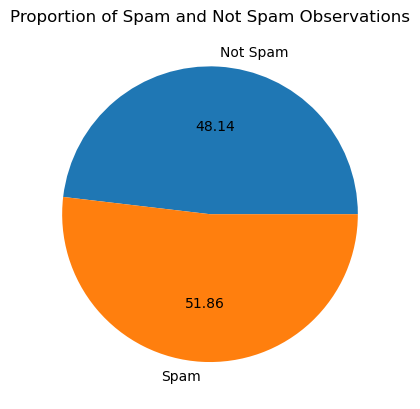

In [5]:
#PIE PLOT Visualizing how many observations of each class training data has
# Calculate counts for each class
spam_count = train_df[train_df['CLASS'] == 1].shape[0]
not_spam_count = train_df[train_df['CLASS'] == 0].shape[0]

# Plot with correct labels
plt.pie([not_spam_count, spam_count], labels=['Not Spam', 'Spam'], autopct="%0.2f")
plt.title('Proportion of Spam and Not Spam Observations')
plt.show()

### 1.2 Date

In [6]:
# Check to see how observations with NA date are distributed
missing_dates_by_class = train_df.groupby('CLASS')['DATE'].apply(lambda x: x.isna().sum())
print("Missing Dates by Class:")
print(f"Not Spam: {missing_dates_by_class[0]}")
print(f"Spam: {missing_dates_by_class[1]}")

Missing Dates by Class:
Not Spam: 0
Spam: 170


### 1.3 Video and User Information

In [7]:
unique_users = train_df['AUTHOR'].nunique()
print(f"Number of unique users in the training data: {unique_users}")
unique_dates = train_df['DATE'].nunique()
print(f"Number of unique dates in the training data: {unique_dates}")

Number of unique users in the training data: 1267
Number of unique dates in the training data: 1199


### 1.4 Comment

#### 1.4.1 Character counts

Maximum number of characters in comments: 1200
Minimum number of characters in comments: 3
Mean number of characters in comments: 95.5989773557341
Mean number of characters in spam comments: 140.80845070422535
Mean number of characters in not spam comments: 46.8907435508346


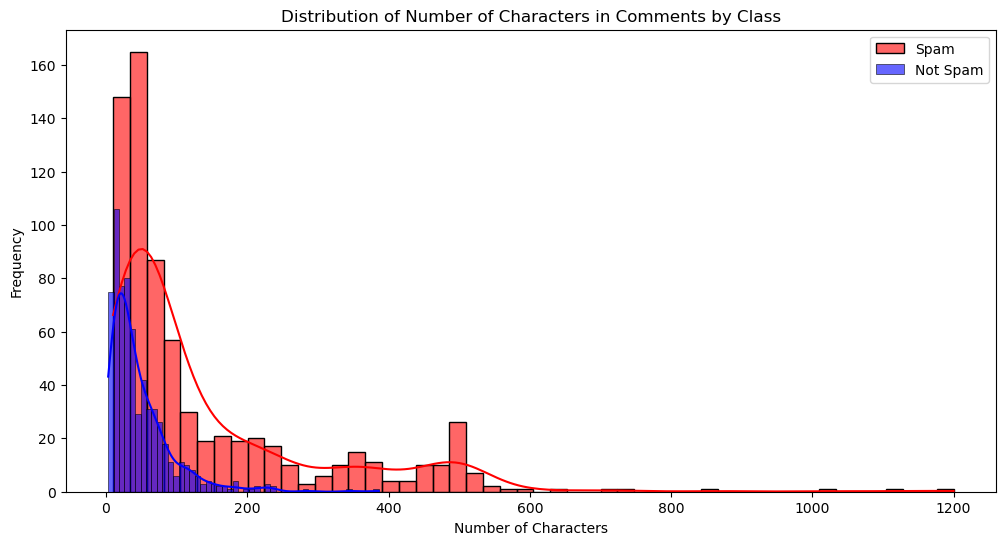

In [8]:
# check for number of characters in each comment
train_df['n_chars'] = train_df['CONTENT'].apply(len)
print(f"Maximum number of characters in comments: {train_df['n_chars'].max()}")
print(f"Minimum number of characters in comments: {train_df['n_chars'].min()}")
print(f"Mean number of characters in comments: {train_df['n_chars'].mean()}")

# check for number of characters based on class
spam_chars = train_df[train_df['CLASS'] == 1]['n_chars']
not_spam_chars = train_df[train_df['CLASS'] == 0]['n_chars']
print(f"Mean number of characters in spam comments: {spam_chars.mean()}")
print(f"Mean number of characters in not spam comments: {not_spam_chars.mean()}")

# Plot the distribution of the number of characters based on class
plt.figure(figsize=(12, 6))
sns.histplot(spam_chars, bins=50, kde=True, color='red', label='Spam', alpha=0.6)
sns.histplot(not_spam_chars, bins=50, kde=True, color='blue', label='Not Spam', alpha=0.6)
plt.title('Distribution of Number of Characters in Comments by Class')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.legend()
plt.show()


#### 1.4.2 Word counts

In [9]:
# basic functions
def clean_text1(text):
    # Remove '\ufeff' if present
    text = text.replace('\ufeff', '')
    # Remove punctuation from the text
    text = text.translate(str.maketrans('', '', string.punctuation))
    # filter out stopwords
    words = text.split()
    stop_words = set(stopwords.words('english'))
    cleaned_words = [word.lower() for word in words if word.lower() not in stop_words]
    return ' '.join(cleaned_words)

def clean_text2(text):
    text = text.replace('www', ' www ')
    text = text.replace('https', ' https ')
    text = text.replace('  ', ' ')
    return text

def tokenize(text):
    sentence_tokenizer = TreebankWordTokenizer()
    lemmatizer = WordNetLemmatizer()
    tokenized_text = sentence_tokenizer.tokenize(text.lower())
    final = [lemmatizer.lemmatize(word) for word in tokenized_text]
    return final

def count_vect(text):
    return ' '.join(text)

def clean_text_eda(text):
    text = clean_text1(text)
    text = clean_text2(text)
    text = tokenize(text)
    return text

def token_to_string(tokens):
    text = ' '.join(tokens)
    text = text.replace('  ', ' ')
    return text

train_df['tokenized'] = train_df['CONTENT'].apply(clean_text_eda)
train_df['cleaned'] = train_df['tokenized'].apply(token_to_string)

Maximum number of words in comments: 99
Minimum number of words in comments: 0
Mean number of words in comments: 9.14463111760409
Mean number of words in spam comments: 13.03943661971831
Mean number of words in not spam comments: 4.948406676783004


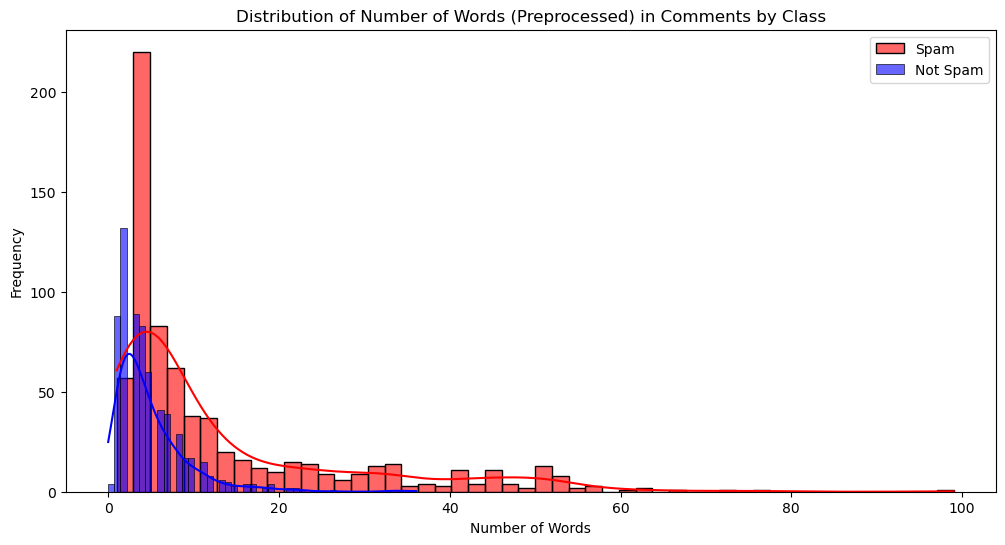

In [10]:
# Calculate the number of words in each comment
train_df['n_words'] = train_df['tokenized'].apply(len)
print(f"Maximum number of words in comments: {train_df['n_words'].max()}")
print(f"Minimum number of words in comments: {train_df['n_words'].min()}")
print(f"Mean number of words in comments: {train_df['n_words'].mean()}")

# Check for number of words based on class
spam_words = train_df[train_df['CLASS'] == 1]['n_words']
not_spam_words = train_df[train_df['CLASS'] == 0]['n_words']
print(f"Mean number of words in spam comments: {spam_words.mean()}")
print(f"Mean number of words in not spam comments: {not_spam_words.mean()}")

# Plot the distribution of the number of words based on class
plt.figure(figsize=(12, 6))
sns.histplot(spam_words, bins=50, kde=True, color='red', label='Spam', alpha=0.6)
sns.histplot(not_spam_words, bins=50, kde=True, color='blue', label='Not Spam', alpha=0.6)
plt.title('Distribution of Number of Words (Preprocessed) in Comments by Class')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.legend()
plt.show()

#### 1.4.3 Frequent words

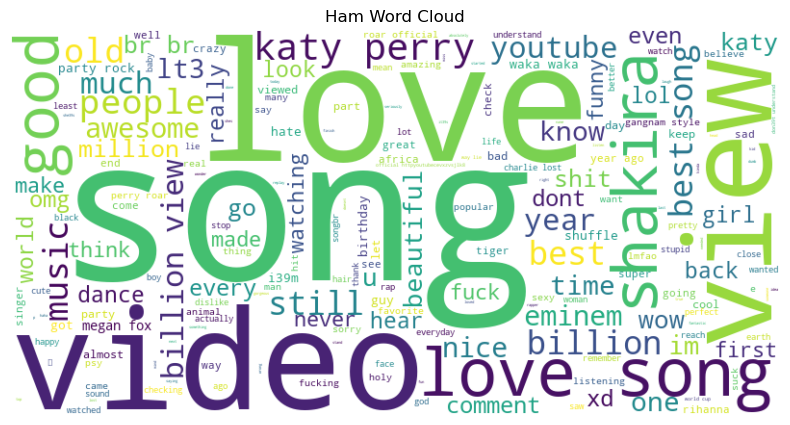

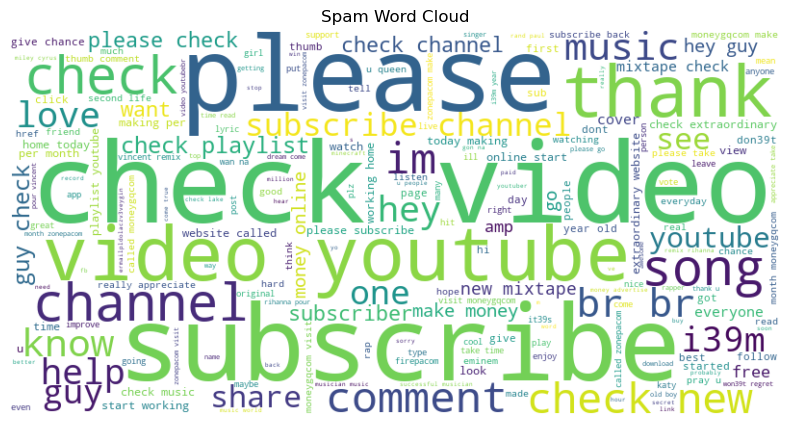

In [11]:
ham_wc = WordCloud(width=800, height=400, background_color='white').generate(train_df[train_df['CLASS'] == 0]['cleaned'].str.cat(sep=" "))
plt.figure(figsize=(10, 5))
plt.imshow(ham_wc, interpolation="bilinear")
plt.axis("off")
plt.title("Ham Word Cloud")
plt.show()

spam_wc = WordCloud(width=800, height=400, background_color='white').generate(train_df[train_df['CLASS'] == 1]['cleaned'].str.cat(sep=" "))
plt.figure(figsize=(10, 5))
plt.imshow(spam_wc, interpolation="bilinear")
plt.axis("off")
plt.title("Spam Word Cloud")
plt.show()

In [12]:
# Filter rows for each class
class_0_words = ' '.join(train_df[train_df['CLASS'] == 0]['cleaned']).split()
class_1_words = ' '.join(train_df[train_df['CLASS'] == 1]['cleaned']).split()

##Word frequency
# Count word occurrences in each class
class_0_word_counts = Counter(class_0_words)
class_1_word_counts = Counter(class_1_words)

# Display the most common words in each class
print("Most common words in class 0:")
print(class_0_word_counts.most_common(10))  # Adjust the number to see more or fewer words
print("\nMost common words in class 1:")
print(class_1_word_counts.most_common(10))

# Find the most frequent words in each class that do not appear in the other class
class_0_only_words = {word: count for word, count in class_0_word_counts.items() if word not in class_1_word_counts}
class_1_only_words = {word: count for word, count in class_1_word_counts.items() if word not in class_0_word_counts}

# Get the top 10 unique words in each class
class_0_unique_top_10 = Counter(class_0_only_words).most_common(10)
class_1_unique_top_10 = Counter(class_1_only_words).most_common(10)

# Display the most frequent words unique to each class
print("\nMost frequent words in class 0 that do not appear in class 1:")
print(class_0_unique_top_10)

print("\nMost frequent words in class 1 that do not appear in class 0:")
print(class_1_unique_top_10)

Most common words in class 0:
[('song', 162), ('love', 104), ('view', 60), ('like', 60), ('video', 56), ('best', 42), ('billion', 40), ('katy', 38), ('2', 36), ('shakira', 32)]

Most common words in class 1:
[('check', 404), ('video', 198), ('please', 159), ('subscribe', 157), ('youtube', 137), ('channel', 126), ('like', 117), ('http', 111), ('music', 89), ('www', 85)]

Most frequent words in class 0 that do not appear in class 1:
[('xd', 11), ('fox', 10), ('megan', 9), ('fuck', 9), ('lost', 7), ('viewed', 7), ('charlie', 6), ('end', 6), ('official', 5), ('favorite', 5)]

Most frequent words in class 1 that do not appear in class 0:
[('cover', 41), ('moneygqcom', 33), ('home', 32), ('playlist', 30), ('website', 30), ('working', 30), ('online', 29), ('free', 28), ('mixtape', 28), ('zonepacom', 27)]


<Figure size 640x480 with 0 Axes>

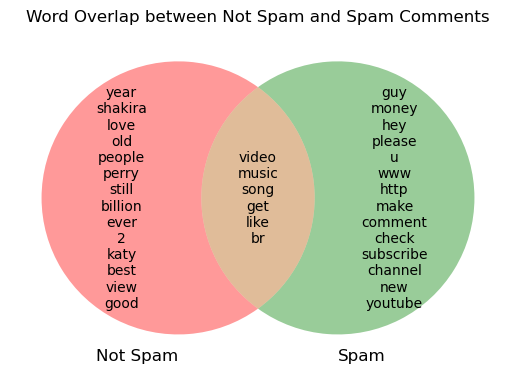

In [13]:
# Create a set of the top N words in each class (N = 20 for example)
top_n = 20
class_0_top_words = {word for word, _ in class_0_word_counts.most_common(top_n)}
class_1_top_words = {word for word, _ in class_1_word_counts.most_common(top_n)}
# Find the overlapping and unique words
overlapping_words = class_0_top_words & class_1_top_words
class_0_unique_words = class_0_top_words - class_1_top_words
class_1_unique_words = class_1_top_words - class_0_top_words

plt.clf()
# Plot the Venn diagram of word overlap
overlap_fig, ax = plt.subplots()
venn = venn2(subsets=(len(class_0_unique_words), len(class_1_unique_words), len(overlapping_words)), set_labels=('Not Spam', 'Spam'))
venn.get_label_by_id('10').set_text('\n'.join(list(class_0_unique_words)))
venn.get_label_by_id('01').set_text('\n'.join(list(class_1_unique_words)))
venn.get_label_by_id('11').set_text('\n'.join(list(overlapping_words)))
plt.title("Word Overlap between Not Spam and Spam Comments")
plt.show()


#### 1.4.4 Typos and Emojis

## 2. Data Preprocessing

### 2.0 Setup

In [13]:
train_df = pd.read_csv('raw-dataset/train.csv')
test_df = pd.read_csv('raw-dataset/test.csv')

### 2.1 Feature Engineering

In [14]:
# date column into binary
train_df['DATE'] = train_df['DATE'].apply(lambda x: 1 if type(x) == float else 0)
test_df['DATE'] = test_df['DATE'].apply(lambda x: 1 if type(x) == float else 0)

### 2.2 Comment Preprocessing

AttributeError: 'str' object has no attribute 'remove'

In [17]:
# basic functions
def clean_text1(text):
    # Remove '\ufeff' if present
    text = text.replace('\ufeff', '')
    # Remove punctuation from the text
    punctuation = string.punctuation.replace("'", "")
    text = text.translate(str.maketrans('', '', punctuation))
    # filter out stopwords
    words = text.split()
    stop_words = set(stopwords.words('english'))
    cleaned_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(cleaned_words)

def clean_text2(text):
    text = text.replace('www', ' www ')
    text = text.replace('https', ' https ')
    text = text.replace('  ', ' ')
    return text

def tokenize(text):
    sentence_tokenizer = TreebankWordTokenizer()
    lemmatizer = WordNetLemmatizer()
    tokenized_text = sentence_tokenizer.tokenize(text.lower())
    final = [lemmatizer.lemmatize(word) for word in tokenized_text]
    return final

def count_vect(text):
    return ' '.join(text)

def clean_text(text):
    text = clean_text1(text)
    text = clean_text2(text)
    text = tokenize(text)
    return count_vect(text)

In [18]:
train_df['cleaned_text'] = train_df['CONTENT'].apply(clean_text)
test_df['cleaned_text'] = test_df['CONTENT'].apply(clean_text)

### 2.3 Word Vectorization: TF-IDF Vectorizer

In [19]:
tf_vectorizer = TfidfVectorizer()
x_1 = tf_vectorizer.fit_transform(list(train_df['cleaned_text'])).toarray()
x_2 = np.array(train_df['DATE']).reshape(-1, 1)
x_tf_idf = np.hstack((x_1, x_2))
y = train_df['CLASS']

## 3. Model Development and Training

### 3.1 Linear Separability: Principal Component Analysis

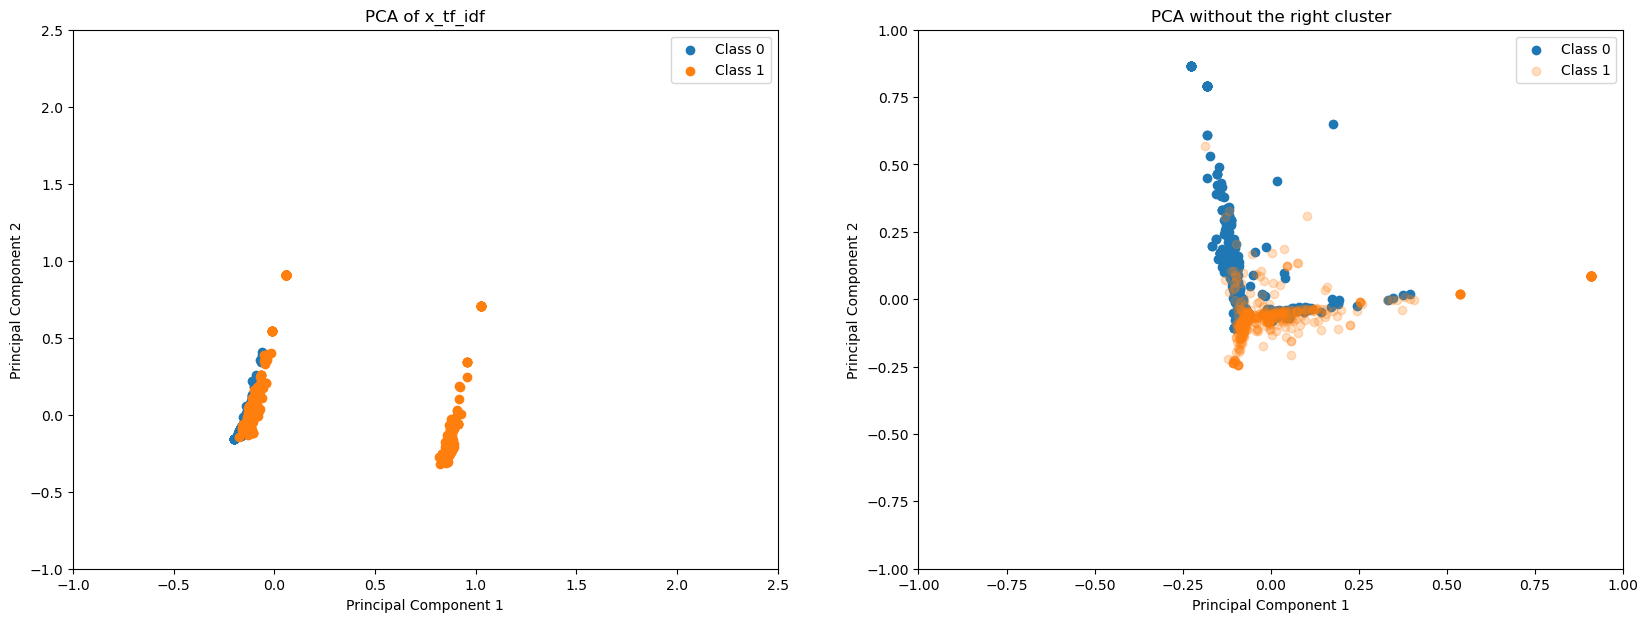

In [20]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 7))

# PCA for tf_idf
pca_tf_idf = PCA(n_components=2)
x_pca_tf_idf = pca_tf_idf.fit_transform(x_tf_idf)

# Plot for tf_idf
axes[0].set_title('PCA of x_tf_idf')
for class_value in np.unique(y):
    axes[0].scatter(x_pca_tf_idf[y == class_value, 0], x_pca_tf_idf[y == class_value, 1], label=f'Class {class_value}')
axes[0].set_xlim(-1, 2.5)
axes[0].set_ylim(-1, 2.5)
axes[0].set_xlabel('Principal Component 1')
axes[0].set_ylabel('Principal Component 2')
axes[0].legend()

# Filtered PCA for tf_idf
right_cluster_threshold = 0.5

pca_tf_idf_temp = PCA(n_components=2)
x_pca_temp = pca_tf_idf_temp.fit_transform(x_tf_idf)

left_cluster_mask = x_pca_temp[:, 0] < right_cluster_threshold
x_tf_idf_left_cluster = x_tf_idf[left_cluster_mask]
y_left_cluster = y[left_cluster_mask]

pca_tf_idf_filtered = PCA(n_components=2)
x_pca_filtered = pca_tf_idf_filtered.fit_transform(x_tf_idf_left_cluster)

axes[1].set_title('PCA without the right cluster')
for class_value in np.unique(y_left_cluster):
    if class_value == 1:
        # Make Class 1 semi-transparent
        axes[1].scatter(x_pca_filtered[y_left_cluster == class_value, 0],
                        x_pca_filtered[y_left_cluster == class_value, 1],
                        label=f'Class {class_value}', alpha=0.25)
    else:
        # Class 0 remains opaque
        axes[1].scatter(x_pca_filtered[y_left_cluster == class_value, 0],
                        x_pca_filtered[y_left_cluster == class_value, 1],
                        label=f'Class {class_value}', alpha=1)

axes[1].set_xlim(-1, 1)
axes[1].set_ylim(-1, 1)
axes[1].set_xlabel('Principal Component 1')
axes[1].set_ylabel('Principal Component 2')
axes[1].legend()

plt.show()

### 3.2 Linear Separability: Hard Margin Support Vector Machine

#### TF-IDF

In [21]:
x_t_train, x_t_test, y_t_train, y_t_test = train_test_split(x_tf_idf, y, test_size=0.2)

In [22]:
# tf_idf
hard_margin_svm = SVC(kernel='linear', C=100000000000)

hard_margin_svm.fit(x_t_train, y_t_train)
y_pred = hard_margin_svm.predict(x_t_test)

tf_idf_hard_margin_svm_accuracy_score = accuracy_score(y_t_test, y_pred)
tf_idf_hard_margin_svm_accuracy_score

0.916058394160584

### 3.3 Model Hyperparameter Tuning

In [71]:
# Initialize the Logistic Regression model
lr_model = LogisticRegression()

param_grid = {
    'C': [100, 500, 1000],
    'solver': ['lbfgs', 'saga'],
    'max_iter': [100, 1000, 10000]
}

t_grid_search = GridSearchCV(estimator=lr_model, param_grid=param_grid, cv=5, scoring='accuracy')
t_grid_search.fit(x_t_train, y_t_train)
t_grid_search.best_params_

{'C': 500, 'max_iter': 100, 'solver': 'lbfgs'}

In [ ]:
# Initial RandomForest model for tuning ccp_alpha
rf = RandomForestClassifier(random_state=42)

param_rf_grid = {
    'max_depth': [50, 100, 150, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


# GridSearch for ccp_alpha
grid_search_alpha = GridSearchCV(estimator=rf, param_grid=param_rf_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_alpha.fit(x_t_train, y_t_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [50, 100, 150, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='accuracy')

Test Accuracy: 0.927007299270073
Recall: 0.8954248366013072
Precision: 0.9716312056737588
False Negative Rate (FNR): 0.10457516339869281
False Positive Rate (FPR): 0.03305785123966942


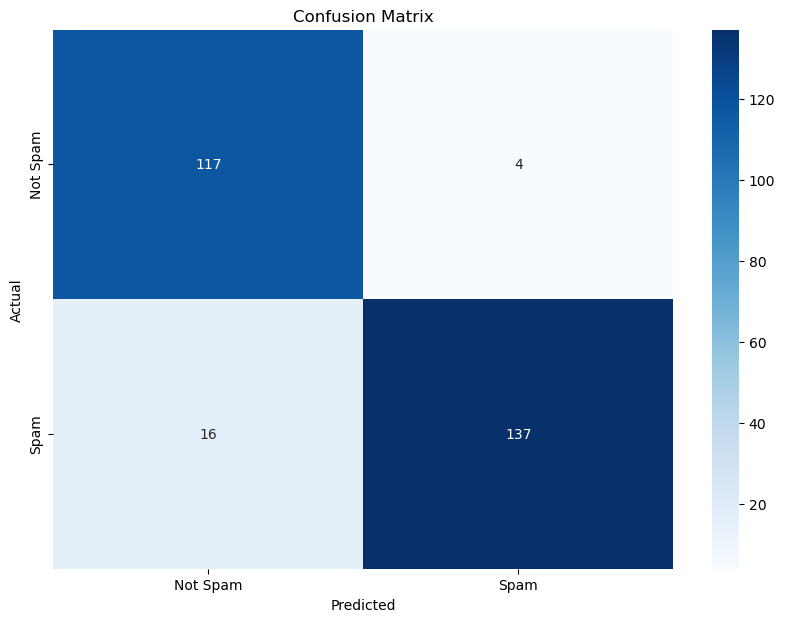

In [25]:
best_model = grid_search_alpha.best_estimator_
y_val_pred = best_model.predict(x_t_test)
val_accuracy = accuracy_score(y_t_test, y_val_pred)
recall = recall_score(y_t_test, y_val_pred)
precision = precision_score(y_t_test, y_val_pred)
print(f"Test Accuracy: {val_accuracy}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")

conf_matrix = confusion_matrix(y_t_test, y_val_pred)

TN, FP, FN, TP = conf_matrix.ravel()

# Calculate FNR and FPR
FNR = FN / (FN + TP)
FPR = FP / (FP + TN)

print(f"False Negative Rate (FNR): {FNR}")
print(f"False Positive Rate (FPR): {FPR}")

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Spam', 'Spam'], yticklabels=['Not Spam', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

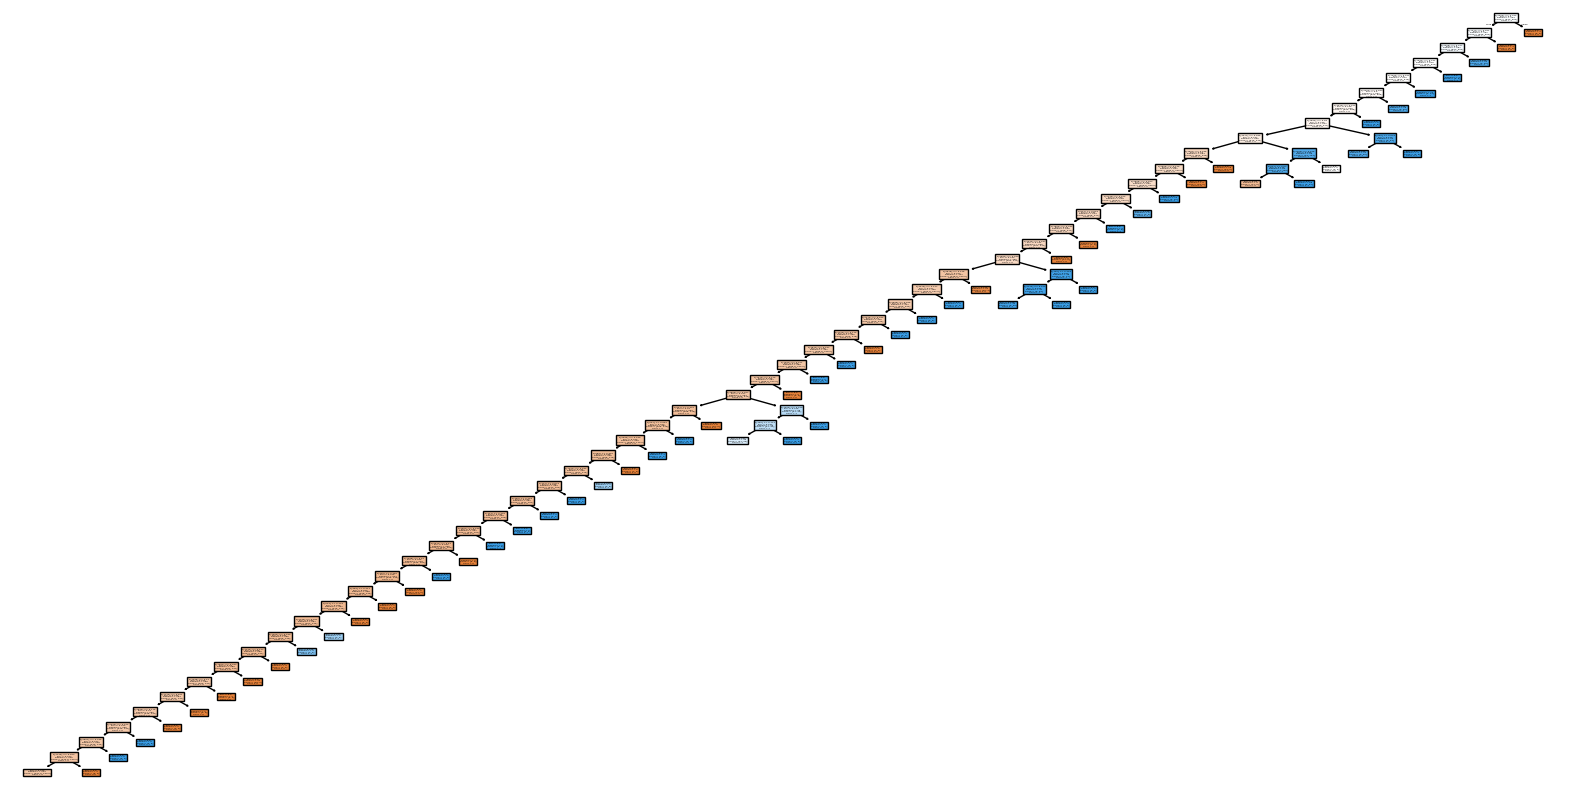

In [26]:
from sklearn.tree import plot_tree
sample_tree = best_model.estimators_[5]

plt.figure(figsize=(20, 10))  # Adjust the size as needed
plot_tree(sample_tree, filled=True, class_names = ['0', '1'])

plt.show()

### 3.4 Model Comparison

#### TF-IDF

In [27]:
lr_t_model = t_grid_search.best_estimator_
rf_t = grid_search_final.best_estimator_

lda_t = LinearDiscriminantAnalysis()
qda_t = QuadraticDiscriminantAnalysis()
gnb_t = GaussianNB()
svc_t = SVC()


NameError: name 't_grid_search' is not defined

In [ ]:
# lda_tv_scores = cross_val_score(lda_t, x_t_train, y_t_train, cv=5)
# qda_tv_scores = cross_val_score(qda_t, x_t_train, y_t_train, cv=5)
# gnb_tv_scores = cross_val_score(gnb_t, x_t_train, y_t_train, cv=5)
svc_tv_scores = cross_val_score(svc_t, x_t_train, y_t_train, cv=5)
# print('LDA:', lda_tv_scores.mean())
# print('QDA:', qda_tv_scores.mean())
# print('GNB:', gnb_tv_scores.mean())
print('SVC:', svc_tv_scores.mean())
print('LR:', t_grid_search.best_score_)
print('RF:', grid_search_final.best_score_)

SVC: 0.9159817351598175
LR: 0.9260273972602739
RF: 0.9242009132420093


In [46]:
feature_names = tf_vectorizer.get_feature_names_out()
importances = rf_t.feature_importances_

In [47]:
tree_structure = decision_tree.tree_
feature_indices = tree_structure.feature

impurity_change = (tree_structure.impurity - tree_structure.impurity[tree_structure.children_left]) * tree_structure.weighted_n_node_samples

# Get the indices of the top 5 nodes with the largest impurity change
top_5_nodes = np.argsort(impurity_change)[-10:]

# Print information about the top 5 nodes
print("Top 10 nodes with the biggest split:")
indices = []
for node in reversed(top_5_nodes):  # Reverse to display in descending order
    left_child = tree_structure.children_left[node]
    right_child = tree_structure.children_right[node]
    indices.append(tree_structure.feature[node])
    print(f"Node {node}: Feature index {tree_structure.feature[node]}, impurity change = {impurity_change[node]:.4f}, samples = {tree_structure.n_node_samples[node]}")


Top 10 nodes with the biggest split:
Node 13: Feature index 1305, impurity change = 25.9393, samples = 426
Node 87: Feature index 2868, impurity change = 15.3424, samples = 125
Node 29: Feature index 2081, impurity change = 13.1293, samples = 265
Node 4: Feature index 3079, impurity change = 9.5092, samples = 587
Node 18: Feature index 1892, impurity change = 7.7848, samples = 362
Node 368: Feature index 518, impurity change = 7.4576, samples = 41
Node 8: Feature index 506, impurity change = 6.8623, samples = 476
Node 15: Feature index 1246, impurity change = 6.3048, samples = 375
Node 115: Feature index 1366, impurity change = 5.2587, samples = 87
Node 88: Feature index 518, impurity change = 4.7136, samples = 119


In [48]:
indices

for index in indices:
    print(feature_names[index])

http
video
please
youtube
new
check
channel
help
i39m
check


## 4. Model Evaluation

## 5. Final Prediction 

In [28]:
test_df['cleaned_text'] = test_df['CONTENT'].apply(clean_text)
test_df['DATE'] = test_df['DATE'].apply(lambda x: 1 if type(x) == float else 0)
tf_vectorizer = TfidfVectorizer()
tf_vectorizer.fit(list(train_df['cleaned_text']))

x_1 = tf_vectorizer.transform(list(train_df['cleaned_text'])).toarray()
x_2 = np.array(train_df['DATE']).reshape(-1, 1)
x = np.hstack((x_1, x_2))
y = train_df['CLASS']

x_test_1 = tf_vectorizer.transform(list(test_df['cleaned_text'])).toarray()
x_test_2 = np.array(test_df['DATE']).reshape(-1, 1)
x_test = np.hstack((x_test_1, x_test_2))

In [29]:
best_params_final = best_model.get_params()

In [30]:
rf = RandomForestClassifier(**best_params_final)
rf.fit(x, y)

RandomForestClassifier(max_depth=50, min_samples_leaf=2, random_state=42)

In [31]:
y_pred = rf.predict(x_test)

In [33]:
sol = pd.read_csv("./sample_submission.csv")
sol['CLASS'] = y_pred
sol.head()
sol.to_csv("tf_idf_rf_nov23.csv", index=False)